In [17]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import resnet50

In [18]:
backbone = models.resnet50(pretrained=True)

c:\Users\vaibh\anaconda3\envs\cs240\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\vaibh\anaconda3\envs\cs240\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
import matplotlib.pyplot as plt
from PIL import Image

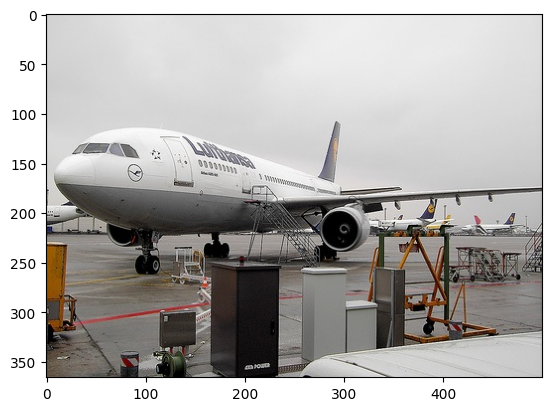

In [20]:
image = Image.open("test.jpg")

plt.imshow(image)

In [21]:
import torchvision.transforms as T

In [22]:
transformer = T.Compose([
    T.Resize((256,256)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]
)

image_tensor = transformer(image).unsqueeze(0)
image_tensor

tensor([[[[ 1.5468,  1.5125,  1.5125,  ...,  1.7352,  1.7180,  1.6838],
          [ 1.4954,  1.4612,  1.4954,  ...,  1.7009,  1.6838,  1.6495],
          [ 1.4954,  1.4783,  1.4954,  ...,  1.6838,  1.6838,  1.6495],
          ...,
          [-0.5082, -0.4226, -0.3883,  ...,  1.2728,  1.2728,  1.2385],
          [-0.4739, -0.4739, -0.4568,  ...,  1.2385,  1.2385,  1.2214],
          [-0.5082, -0.4226, -0.4054,  ...,  1.2214,  1.2214,  1.2214]],

         [[ 1.7108,  1.6758,  1.6758,  ...,  1.9034,  1.8859,  1.8508],
          [ 1.6583,  1.6232,  1.6583,  ...,  1.8683,  1.8508,  1.8158],
          [ 1.6583,  1.6408,  1.6583,  ...,  1.8508,  1.8508,  1.8158],
          ...,
          [-0.6176, -0.5301, -0.5126,  ...,  1.4307,  1.4132,  1.3606],
          [-0.5826, -0.5826, -0.5651,  ...,  1.3957,  1.3957,  1.3606],
          [-0.6176, -0.5301, -0.5126,  ...,  1.3782,  1.3782,  1.3431]],

         [[ 1.9254,  1.8905,  1.8905,  ...,  2.1171,  2.0997,  2.0648],
          [ 1.8731,  1.8383,  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5702832].


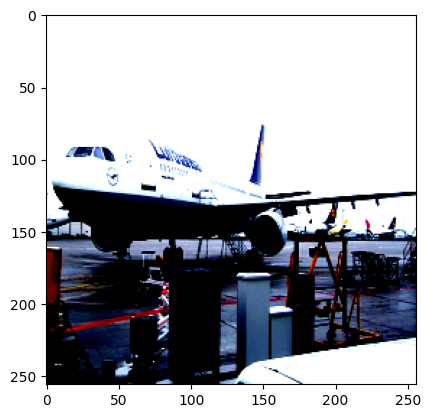

In [23]:
plt.imshow(image_tensor[0].permute(1,2,0).numpy())

In [24]:
class ResNetBackbone(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = resnet50(pretrained=True)
        self.stage0 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu)  # /2
        self.stage1 = nn.Sequential(resnet.maxpool, resnet.layer1)  # /4
        self.stage2 = resnet.layer2  # /8
        self.stage3 = resnet.layer3  # /16
        self.stage4 = resnet.layer4  # /32

    def forward(self, x):
        features = []
        x = self.stage0(x); features.append(x)
        x = self.stage1(x); features.append(x)
        x = self.stage2(x); features.append(x)
        x = self.stage3(x); features.append(x)
        x = self.stage4(x); features.append(x)
        return features 

In [25]:
backbone = ResNetBackbone()
x = image_tensor
features = backbone(x)

for i, feat in enumerate(features):
    print(f"Feature {i} shape: {feat.shape}")


c:\Users\vaibh\anaconda3\envs\cs240\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\vaibh\anaconda3\envs\cs240\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Feature 0 shape: torch.Size([1, 64, 128, 128])
Feature 1 shape: torch.Size([1, 256, 64, 64])
Feature 2 shape: torch.Size([1, 512, 32, 32])
Feature 3 shape: torch.Size([1, 1024, 16, 16])
Feature 4 shape: torch.Size([1, 2048, 8, 8])


In [28]:
import torch.nn.functional as F


In [31]:
M5 =  nn.Conv2d(in_channels=2048, out_channels=256, kernel_size=1)(features[-1])
M5.shape

torch.Size([1, 256, 8, 8])

In [42]:
upsampled_M5 = F.interpolate(M5, size=(16, 16), mode='nearest')
lateral_C4 = nn.Conv2d(in_channels=1024, out_channels=256, kernel_size=1)(features[-2])
M4 = lateral_C4 + upsampled_M5
smooth_conv3x3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
M4 = smooth_conv3x3(M4) 
print(M4.shape)

torch.Size([1, 256, 16, 16])


In [44]:
upsampled_M4 = F.interpolate(M4, size=(32, 32), mode='nearest')
lateral_C3 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1)(features[-3])
M3 = lateral_C3 + upsampled_M4
smooth_conv3x3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
M3 = smooth_conv3x3(M3) 
print(M3.shape)

torch.Size([1, 256, 32, 32])


In [47]:
upsampled_M3 = F.interpolate(M3, size=(64, 64), mode='nearest')
lateral_C2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1)(features[-4])
M2 = lateral_C2 + upsampled_M3
smooth_conv3x3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
M2 = smooth_conv3x3(M2) 
print(M2.shape)

torch.Size([1, 256, 64, 64])


In [48]:
upsampled_M2 = F.interpolate(M2, size=(128, 128), mode='nearest')
lateral_C1 = nn.Conv2d(in_channels=64, out_channels=256, kernel_size=1)(features[0])
M1 = lateral_C1 + upsampled_M2
smooth_conv3x3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
M1 = smooth_conv3x3(M1) 
print(M1.shape)

torch.Size([1, 256, 128, 128])


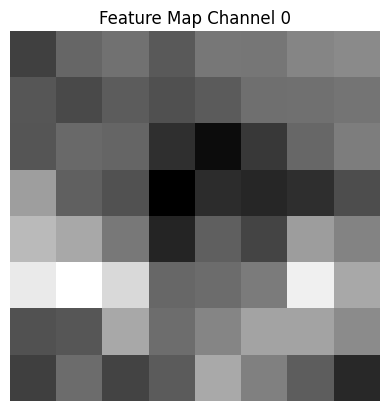

In [60]:
plt.imshow(M5[0][54].detach().cpu().numpy(), cmap='gray')
plt.title("Feature Map Channel 0")
plt.axis('off')
plt.show()
